<a href="https://colab.research.google.com/github/Alex112525/LangGraph-notebooks/blob/main/Agents_with_memory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install langgraph langgraph-sdk langgraph-checkpoint-sqlite langsmith langchain-community langchain-core langchain-openai tavily-python wikipedia

In [2]:
import os
from google.colab import userdata
from IPython.display import Image, display

In [3]:
from langchain_openai import AzureChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_community.retrievers import TavilySearchAPIRetriever

In [4]:
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

In [5]:
os.environ["AZURE_OPENAI_API_KEY"] = userdata.get('Azure_openai')
os.environ["AZURE_OPENAI_ENDPOINT"] = userdata.get('Endpoint_openai')

### LangSmith

We can use LangSmith to trace all the behavior of the agent

In [6]:
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LangSmith')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-agents-practice"

## Utils Funtions

In [7]:
def get_model(model:str="DASH-mini", temp:float=0.1, max_tokens:int=100):
  """Get model from Azure OpenAI"""
  model = AzureChatOpenAI(
        openai_api_version="2024-02-15-preview",
        azure_deployment=model,
        temperature=temp,
        max_tokens=max_tokens,
    )
  return model

#### Tools

In [8]:
def sum(a:float, b:float) -> float:
  """Sum a and b

  Args:
    a: first number
    b: second number"""
  return a+b

def minus(a:float, b:float) -> float:
  """Minus a and b

  Args:
    a: first number
    b: second number"""
  return a-b

def multiply(a:float, b:float) -> float:
  """Multiply a and b

  Args:
    a: first number
    b: second number"""
  return a*b

def divide(a:float, b:float) -> float:
  """Divide a and b

  Args:
    a: first number
    b: second number"""
  return a/b if b != 0 else "We cannot divide by zero"

#### Model binding

__“binding”__ tools refers to the process of connecting or associating specific tools or functions with the model so that it can use them during its operations.

In [9]:
llm = get_model()
llm_with_tools = llm.bind_tools(
    tools=[sum, minus, multiply, divide]
)

In [10]:
# System Message
sys_msg = SystemMessage(content="You are a helpful mathematical assistant, tasked with performing arithmetic in order on a set of inputs.")

def assistant(state: MessagesState):
  return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

### Build Agent and test

The agent can go back to the Assistant to perform additional operations as needed.

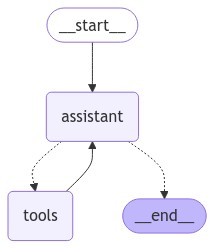

In [11]:
# Build Graph
builder = StateGraph(MessagesState)
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode([sum, minus, multiply, divide]))

builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition) # If latest message is a tool Call -> routes Tool else routes END
builder.add_edge("tools", "assistant")

# Add Memory
memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer=memory)

# View graph
display(Image(react_graph_memory.get_graph().draw_mermaid_png()))

When we use memory, we need to specify a thread_id.

This thread_id will store our collection of graph states.

In [12]:
# Specify a thread
config = {"configurable": {"thread_id": "1"}}

In [13]:
step = 0

In [14]:
messages = [HumanMessage(content="Hello my name is Alex")]

# Run
messages = react_graph_memory.invoke({"messages": messages}, config)
# Print
for m in messages["messages"][step:]:
  m.pretty_print()
  step += 1

================================ Human Message =================================

Hello my name is Alex
================================== Ai Message ==================================

Hello Alex! How can I assist you today?


In [15]:
messages = [HumanMessage(content="Please add 7 and 5. Multiply by 3. Divide by 9")]

# Run
messages = react_graph_memory.invoke({"messages": messages}, config)

# Print
for m in messages["messages"][step:]:
  m.pretty_print()
  step += 1

================================ Human Message =================================

Please add 7 and 5. Multiply by 3. Divide by 9
================================== Ai Message ==================================
Tool Calls:
  sum (call_3IZSy9L1WWEFBeMHqWDLoedG)
 Call ID: call_3IZSy9L1WWEFBeMHqWDLoedG
  Args:
    a: 7
    b: 5
  multiply (call_n2D1jGqBxX6Q3ZmQyWnbyeaC)
 Call ID: call_n2D1jGqBxX6Q3ZmQyWnbyeaC
  Args:
    a: 12
    b: 3
  divide (call_OrYOmVQ7k32SOvbmWrX7pSLj)
 Call ID: call_OrYOmVQ7k32SOvbmWrX7pSLj
  Args:
    a: 36
    b: 9
================================= Tool Message =================================
Name: sum

12.0
================================= Tool Message =================================
Name: multiply

36.0
================================= Tool Message =================================
Name: divide

4.0
================================== Ai Message ==================================

Here are the results of your calculations:

1. \( 7 + 5 = 12 \)
2. \( 12 \ti

In [16]:
messages = [HumanMessage(content="Then Multiply by 100")]

# Run
messages = react_graph_memory.invoke({"messages": messages}, config)

# Print
for m in messages["messages"][step:]:
  m.pretty_print()
  step += 1

================================ Human Message =================================

Then Multiply by 100
================================== Ai Message ==================================
Tool Calls:
  multiply (call_lWU7UQABsJfV8pBWcKoNFfMS)
 Call ID: call_lWU7UQABsJfV8pBWcKoNFfMS
  Args:
    a: 4
    b: 100
================================= Tool Message =================================
Name: multiply

400.0
================================== Ai Message ==================================

Multiplying by 100 gives you \( 4 \times 100 = 400 \). 

If you have any more calculations or questions, just let me know!


In [17]:
messages = [HumanMessage(content="You remember my name?")]

# Run
messages = react_graph_memory.invoke({"messages": messages}, config)

# Print
for m in messages["messages"][step:]:
  m.pretty_print()
  step += 1

================================ Human Message =================================

You remember my name?
================================== Ai Message ==================================

Yes, your name is Alex! How can I assist you further?


### Trace in LangGraph

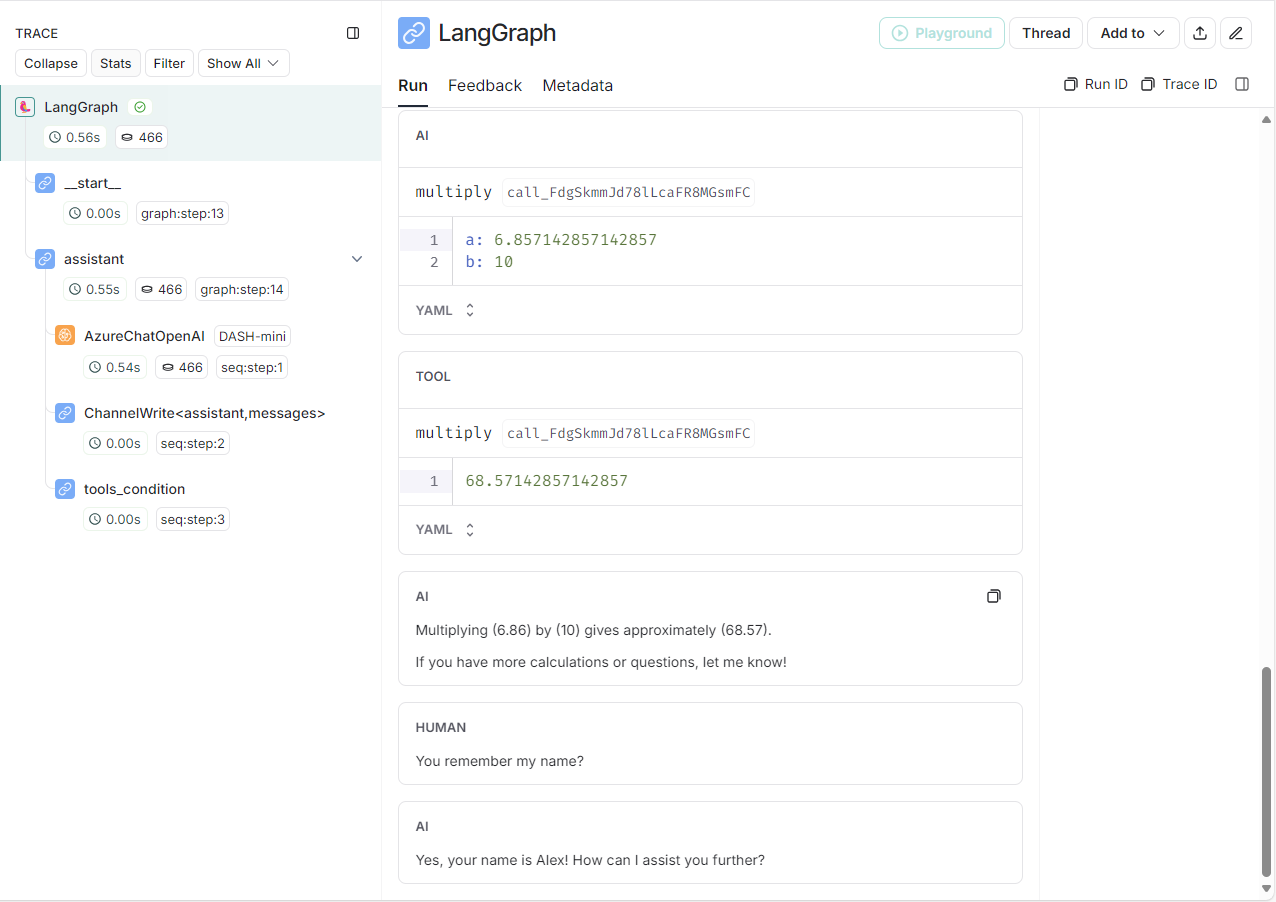